Import Dependencies

In [1]:
%matplotlib inline
import os
import sys
import platform
import matplotlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.ticker as tick
from matplotlib.backends.backend_pdf import PdfPages
from datetime import datetime,timedelta
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10

In [1]:
import ipywidgets as widgets
widgets.Widget.widget_types.values()
from IPython.display import display
import traitlets

In [3]:
# custom functions for transducer data import
#import Snake_Valley_Data_Import as svdi
import wellapplication as svdi

Declare software versions

In [4]:
print("Operating System " + platform.system() + " " + platform.release())
print("Python Version " + str(sys.version))
print("Pandas Version " + str(pd.__version__))
print("Numpy Version " + str(np.__version__))
print("Matplotlib Version " + str(matplotlib.__version__))

Operating System Windows 7
Python Version 2.7.10 (default, May 23 2015, 09:40:32) [MSC v.1500 32 bit (Intel)]
Pandas Version 0.19.1
Numpy Version 1.11.2
Matplotlib Version 1.5.3


Designate root environments

In [7]:
drive = 'H:'
raw_archive_folder = drive + '/PROJECTS/Snake Valley Water/Transducer Data/Raw_data_archive'
folder = raw_archive_folder + '/2016/2016 q2/'
enteredFolder = folder + '/entered/'
checkFolder = folder + '/toCheck/'
wellinfofile = drive + raw_archive_folder + '/well table 2015-03-23.csv'

Import Connection Info For Database

In [9]:
connection_filepath = "E:\Google Drive\WORK\Groundwater Chemistry"
sys.path.append(connection_filepath)
import oraconnection

ImportError: No module named engineGetter

In [ ]:
if not os.path.exists(enteredFolder):
    print('Creating Output Folder')
    os.makedirs(enteredFolder)
else:
    print('Output Folder Exists')

In [ ]:
if not os.path.exists(checkFolder):
    print('Creating Check Folder')
    os.makedirs(checkFolder)
else:
    print('Check Folder Exists')

## Import Relevant Data

### Well Information

In [11]:
wellinf = pd.read_csv(raw_archive_folder + '/well table 2015-03-23.csv',index_col=0)
wellinf["G_Elev_m"] = wellinf["GroundElevation"]/3.2808
wellinf["Well"] = wellinf['Well'].apply(lambda x: str(x).lower().strip())
wellinf['WellID'] = wellinf.index.values
#wellinfo = svdi.barodistance(wellinfo)
wellinfo = svdi.make_files_table(folder, wellinf)
wellinfo.to_csv(folder+"/wellinfo4.csv")

### Manual Water Levels

In [12]:
manualwls = raw_archive_folder + "/All tape measurements.csv"
manual = pd.read_csv(manualwls, index_col="DateTime", engine="python")

### New Barometric Pressure Data

In [13]:
pw03baro_append = folder + "\\pw03 baro 2016-08-03.xle"
pw10baro_append = folder + "\\pw10 baro 2016-08-03.xle"
pw19baro_append = folder + "\\pw19 baro 2016-08-04.xle"

## Compile Barometric Pressure Data

Skip this section if you have already compiled the data to save on processing time.

### Call Up Existing Data

In [12]:
pw03baro = raw_archive_folder + "\\pw03baro.csv"
pw10baro = raw_archive_folder + "\\pw10baro.csv"
pw19baro = raw_archive_folder +  "\\pw19baro.csv"

### Append New Data to Existing Data

In [13]:
svdi.appendomatic(pw03baro_append,pw03baro)
svdi.appendomatic(pw10baro_append,pw10baro)
svdi.appendomatic(pw19baro_append,pw19baro)

In [14]:
# duplicated to update changes made by appendomatic
pw03baro = pd.read_csv(raw_archive_folder + "\\pw03baro.csv",index_col='DateTime',parse_dates=True)
pw10baro = pd.read_csv(raw_archive_folder + "\\pw10baro.csv",index_col='DateTime',parse_dates=True)
pw19baro = pd.read_csv(raw_archive_folder + "\\pw19baro.csv",index_col='DateTime',parse_dates=True)

In [15]:
pw03baro['pw03'] = pw03baro['Level']
pw03baro = svdi.hourly_resample(pw03baro['pw03'].to_frame())
pw10baro['pw10'] = pw10baro['Level']
pw10baro = svdi.hourly_resample(pw10baro['pw10'].to_frame())
pw19baro['pw19'] = pw19baro['Level']
pw19baro = svdi.hourly_resample(pw19baro['pw19'].to_frame())

In [16]:
baro = pd.merge(pw03baro,pw10baro,how="outer",left_index=True,right_index=True)
baro = pd.merge(baro,pw19baro,how="outer",left_index=True,right_index=True)
baro.dropna(axis=0,inplace=True)
baro['integr'] = 0 #for vented transducers

In [17]:
baro[baro.index.to_datetime()==pd.datetime(2015,11,15,10)]

,pw03,pw10,pw19,integr
DateTime,,,,
2015-11-15 10:00:00,2.4887,2.89,2.9464,0


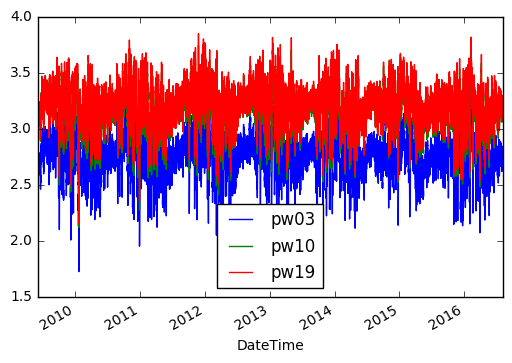

In [18]:
baro[['pw03','pw10','pw19']].plot()

In [19]:
baro.to_csv(raw_archive_folder + '\\baro.csv')

## Water Level Tranducer Data

### Export and Plot Data

#### Export Manual Data

In [19]:
manualwls = raw_archive_folder + "\\All tape measurements.csv"
manual = pd.read_csv(manualwls, index_col="DateTime", engine="python")
manualrecent = manual[manual.index.to_datetime() > pd.datetime(2015,6,1)]
manualrecent.dropna(inplace=True)
manualrecent.reset_index(inplace=True)
print manualrecent.dtypes
manualrecent = pd.merge(manualrecent, wellinfo, how='left',left_on='WellID', right_index=True)
manualrecent.loc[:,"MeasuredLevel"] = np.nan
manualrecent.loc[:,"Temp"] = np.nan
manualrecent.loc[:,"BaroEfficiencyCorrected"] = np.nan 
manualrecent.loc[:,"DeltaLevel"] = np.nan
manualrecent.loc[:,"DriftCorrection"] = np.nan
manualrecent.loc[:,"MeasuredBy"] = np.nan
manualrecent.loc[:,"Tape"] = 1
manualrecent.loc[:,"DTWBelowGroundSurface"] = np.nan
manualrecent.loc[:,"WaterElevation"] = np.nan
#manualrecent["DTWBelowGroundSurface"] = np.nan
manualrecent.loc[:,"DTWBelowCasing"] = manualrecent.loc[:,"MeasuredDTW"]
manualrecent.loc[:,"DTWBelowGroundSurface"] = manualrecent.loc[:,"MeasuredDTW"] - manualrecent.loc[:,"Offset"]
manualrecent.loc[:,"WaterElevation"] = manualrecent.loc[:,'GroundElevation'] - manualrecent.loc[:,"DTWBelowGroundSurface"]
print manualrecent

#outpath = pathlist[0] + '\\' + pathlist[1] + '\\' + pathlist[2] + '\\' + pathlist[3] + '\\' + pathlist[4] + '\\' + 'Manual' + '.csv'  
manualrecent.to_csv(raw_archive_folder+ 'Manual' + '.csv', index=True, columns= ["WellID","DateTime","MeasuredLevel","Temp","BaroEfficiencyCorrected","DeltaLevel",
                                             "MeasuredDTW","DriftCorrection","DTWBelowCasing","DTWBelowGroundSurface",
                                             "WaterElevation","Tape","MeasuredBy"])

DateTime        object
WellID         float64
MeasuredDTW    float64
WellName        object
dtype: object
            DateTime  WellID_x  MeasuredDTW                  WellName  \
0    6/23/2015 14:47      21.0        41.35                    PW07MX   
1    6/23/2015 14:51      20.0        48.54                     PW07B   
2    6/23/2015 14:53      19.0        46.77                     PW07A   
3    6/23/2015 15:50      23.0       101.97                     PW08B   
4    6/23/2015 15:54      22.0       102.30                     PW08A   
5    6/23/2015 16:15      30.0       210.44                     PW11D   
6    6/23/2015 16:17      31.0       210.33                     PW11E   
7    6/23/2015 16:21      28.0       215.52                     PW11B   
8    6/23/2015 16:25      29.0       215.05                     PW11C   
9    6/23/2015 16:52      72.0         8.42          Needle Point BLM   
10   6/23/2015 16:58      57.0         9.35                     SG23B   
11   6/23/2015 17:

c:\users\paulinkenbrandt\documents\github\env\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [20]:
manual['DateTime'] = manual.index.to_datetime()
manual.to_csv(raw_archive_folder+ 'Manual' + '.csv', index=False, columns= ["WellID","DateTime","MeasuredLevel","Temp","BaroEfficiencyCorrected","DeltaLevel",
                                             "MeasuredDTW","DriftCorrection","DTWBelowCasing","DTWBelowGroundSurface",
                                             "WaterElevation","Tape","MeasuredBy"])

#### List Files to Export

In [21]:
print wellinfo.loc[:,'full_file_name']

0                     ag13a 2016-08-02.xle
1                     ag13b 2016-08-02.xle
2                     ag13c 2016-08-02.xle
3                     ag14a 2016-08-02.csv
4                     ag14b 2016-08-02.csv
5                     ag14c 2016-08-02.xle
6                      ag15 2016-08-02.csv
7                     ag16a 2016-08-02.xle
8                     ag16b 2016-08-02.xle
9           central tule mx 2016-08-03.xle
10               eskdale mx 2016-08-02.csv
11                    pw01a 2016-08-02.xle
12                    pw01b 2016-08-02.xle
13                    pw01c 2016-08-02.csv
14                    pw02a 2016-08-01.xle
15                    pw02b 2016-08-01.xle
16                    pw03a 2016-08-03.xle
17                    pw03b 2016-08-03.xle
18                    pw03z 2016-08-03.xle
19                    pw04a 2016-08-02.csv
20                    pw04b 2016-08-02.csv
21                    pw05a 2016-08-02.xle
22                    pw05b 2016-08-02.csv
23         

## Files To Database

In [14]:
manualwls = raw_archive_folder + '/All tape measurements.csv'
manual = pd.read_csv(manualwls, index_col="DateTime", engine="python")
barofile = raw_archive_folder + '/baro.csv'
baro = pd.read_csv(barofile,index_col=0, parse_dates=True)
wellinfo = pd.read_csv(folder + '/wellinfo4.csv')

In [15]:
engine = engineGetter.getEngine()

### Add Select Wells

In [17]:
form = widgets.VBox()
welllist = ["pw07mx 2015-11-30.csv","pw02a 11-30-2015.xle","pw02a 2016-07-07.xle","sg23b 2016-05-02.xle"]
welllist = welllist+ list(wellinfo.loc[:,'full_file_name'].values)
#print welllist

wells = widgets.SelectMultiple(description="Well", options=welllist, padding=4)
pdfName = widgets.Text(description="PDF:",padding=4)
driftTol = widgets.FloatSlider(value=0.05, min=0.00, max=10.0, step=0.05, description='Drift Tolerance:')
form.children = [wells, pdfName, driftTol]
display(form)

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


In [ ]:
for i in wells.value:
    print folder+'/'+i
    inputfile = folder +'/'+i
    g, drift, wellname = svdi.imp_new_well(inputfile, wellinfo, manual, baro)
    glist = g.columns.tolist()
    y1 = g['WaterElevation'].values
    y2 = baro['pw03'].values
    x1 = g.index.values
    x2 = baro.index.values
    wellname, wellid = svdi.getwellid(folder+'\\'+i,wellinfo)
    ylast = wellinfo[wellinfo['WellID']==wellid]['GroundElevation'].values[0] + wellinfo[wellinfo['WellID']==wellid]['Offset'].values[0] - svdi.fcl(manual[manual['WellID']== wellid],max(g.index.to_datetime()))[1]
    yfirst = wellinfo[wellinfo['WellID']==wellid]['GroundElevation'].values[0] + wellinfo[wellinfo['WellID']==wellid]['Offset'].values[0] - svdi.fcl(manual[manual['WellID']== wellid],min(g.index.to_datetime()))[1]
    xlast = pd.to_datetime((svdi.fcl(manual[manual['WellID']== wellid],max(pd.to_datetime(g.index)))).name)
    xfirst = pd.to_datetime((svdi.fcl(manual[manual['WellID']== wellid],min(pd.to_datetime(g.index)))).name)
    x4 = [xfirst,xlast]
    y4 = [yfirst,ylast]
    fig, ax1 = plt.subplots()
    ax1.scatter(x4,y4,color='purple')
    ax1.plot(x1,y1,color='blue',label='Water Level Elevation')
    ax1.set_ylabel('Water Level Elevation',color='blue')
    y_formatter = tick.ScalarFormatter(useOffset=False)
    ax1.yaxis.set_major_formatter(y_formatter)
    ax2 = ax1.twinx()
    ax2.set_ylabel('Barometric Pressure (ft)', color='red') 
    ax2.plot(x2,y2,color='red',label='Barometric pressure (ft)')
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1+h2, l1+l2, loc=3)
    plt.xlim(xfirst-timedelta(days=3),xlast+timedelta(days=3))
    plt.title('Well: ' + wellname.title() + '  ' + 'Total Drift = ' + str(g['DriftCorrection'][-1]))

M:/PROJECTS/Snake Valley Water/Transducer Data/Raw_data_archive/2016/2016 q2//pw04b 2016-08-02.csv
Well = pw04b


c:\users\paulinkenbrandt\documents\github\env\lib\site-packages\pandas\core\generic.py:5128: RuntimeWarning: invalid value encountered in absolute
  return np.abs(self)


Dropped from beginning to 2


In [65]:
pdf_pages = PdfPages(folder + '/' + pdfName.value + '.pdf')
for i in wells.value:
    print folder+'/'+i
    inputfile = folder +'/'+i
    g, drift, wellname = svdi.imp_new_well(inputfile, wellinfo, manual, baro)
    quer = "SELECT * FROM groundwater.reading where WellID = " + str(g['WellID'].values[0]) + " and DateTime > \'" + str(g.index.values[-1])[0:10] + " "+ str(g.index.values[-1])[11:19] + "\'"

    if abs(float(drift)) < driftTol.value:
        if len(pd.read_sql_query(sql=quer,con=engine))<1:
            g.to_csv(enteredFolder+wellname+".csv", index=False)
            tablename = 'reading'
            g.to_sql(con=engine, name = tablename, if_exists='append', flavor='mysql', index=False)
            print("Added to DB table " + tablename)
        else:
            print("Already Entered")
            print(len(pd.read_sql_query(sql=quer,con=engine)))
    else:
        g.to_csv(checkFolder+wellname+".csv", index=False, columns= ["WellID","DateTime","MeasuredLevel","Temp","BaroEfficiencyCorrected","DeltaLevel",
                                             "MeasuredDTW","DriftCorrection","DTWBelowCasing","DTWBelowGroundSurface",
                                             "WaterElevation","Tape","MeasuredBy"])
        print("Check File")
    glist = g.columns.tolist()
    for j in range(len(glist)):
        if 'pw' in glist[j]:
            h = glist[j]
    y1 = g['WaterElevation'].values
    y2 = baro['pw03'].values
    x1 = g.index.values
    x2 = baro.index.values
    wellname, wellid = svdi.getwellid(folder+'\\'+i,wellinfo)
    ylast = wellinfo[wellinfo['WellID']==wellid]['GroundElevation'].values[0] + wellinfo[wellinfo['WellID']==wellid]['Offset'].values[0] - svdi.fcl(manual[manual['WellID']== wellid],max(pd.to_datetime(g.index)))[1]
    yfirst = wellinfo[wellinfo['WellID']==wellid]['GroundElevation'].values[0] + wellinfo[wellinfo['WellID']==wellid]['Offset'].values[0] - svdi.fcl(manual[manual['WellID']== wellid],min(pd.to_datetime(g.index)))[1]
    xlast = pd.to_datetime(svdi.fcl(manual[manual['WellID']== wellid],max(pd.to_datetime(g.index))).name)
    xfirst = pd.to_datetime(svdi.fcl(manual[manual['WellID']== wellid],min(pd.to_datetime(g.index))).name)
    x4 = [xfirst,xlast]
    y4 = [yfirst,ylast]
    fig, ax1 = plt.subplots()
    ax1.scatter(x4,y4,color='purple')
    ax1.plot(x1,y1,color='blue',label='Water Level Elevation')
    ax1.set_ylabel('Water Level Elevation',color='blue')
    y_formatter = tick.ScalarFormatter(useOffset=False)
    ax1.yaxis.set_major_formatter(y_formatter)
    ax2 = ax1.twinx()
    ax2.set_ylabel('Barometric Pressure (ft)', color='red') 
    ax2.plot(x2,y2,color='red',label='Barometric pressure (ft)')
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1+h2, l1+l2, loc=3)
    plt.xlim(xfirst-timedelta(days=3),xlast+timedelta(days=3))
    plt.title('Well: ' + wellname.title() + '  ' + 'Total Drift = ' + str(g['DriftCorrection'][-1]))
    
    pdf_pages.savefig(fig)
    plt.close()
pdf_pages.close()
print("DONE!")
print("Files in "+ folder+'\\wells.pdf')
print(datetime.now())

M:/PROJECTS/Snake Valley Water/Transducer Data/Raw_data_archive/2016//sg23b 2016-05-02.xle
Well = sg23b
Dropped from end to 2016-05-02 15:00:00
No BP match, using pw03
Efficiency = 0.1
Max Drift = -0.0355
Added to DB table reading
DONE!
Files in M:/PROJECTS/Snake Valley Water/Transducer Data/Raw_data_archive/2016/\wells.pdf
2016-05-31 10:58:52.224000


### Add All Wells (with small drift)

In [24]:
form = widgets.VBox()
driftTol = widgets.FloatSlider(value=0.05, min=0.00, max=10.0, step=0.05, description='Drift Tolerance:')
form.children = [driftTol]
display(form)

In [28]:
pdf_pages = PdfPages(folder + '/wells.pdf')
for i in wellinfo.loc[:,'full_file_name']:
    print folder+'/'+i
    inputfile = folder +'/'+i
    g, drift, wellname = svdi.imp_new_well(inputfile, wellinfo, manual, baro)
    quer = "SELECT * FROM groundwater.reading where WellID = " + str(g['WellID'].values[0]) + " and (DateTime >= \'" + str(g.index.values[-1])[0:10] + "\')"

    if abs(float(drift)) < driftTol.value:
        if len(pd.read_sql_query(sql=quer,con=engine))<1:
            g.to_csv(enteredFolder + wellname+".csv", index=False)
            g.to_sql(con=engine, name='reading', if_exists='append', flavor='mysql', index=False)
            print("Added to DB")
        else:
            print("Already Entered")
    else:
        g.to_csv(checkFolder + wellname+".csv", index=False, columns= ["WellID","DateTime","MeasuredLevel","Temp","BaroEfficiencyCorrected","DeltaLevel",
                                             "MeasuredDTW","DriftCorrection","DTWBelowCasing","DTWBelowGroundSurface",
                                             "WaterElevation","Tape","MeasuredBy"])
        print("Check File")
    glist = g.columns.tolist()
    for j in range(len(glist)):
        if 'pw' in glist[j]:
            h = glist[j]
    y1 = g['WaterElevation'].values
    y2 = baro['pw03'].values
    x1 = g.index.values
    x2 = baro.index.values
    wellname, wellid = svdi.getwellid(folder+'\\'+i,wellinfo)
    ylast = wellinfo[wellinfo['WellID']==wellid]['GroundElevation'].values[0] + wellinfo[wellinfo['WellID']==wellid]['Offset'].values[0] - svdi.fcl(manual[manual['WellID']== wellid],max(pd.to_datetime(g.index)))[1]
    yfirst = wellinfo[wellinfo['WellID']==wellid]['GroundElevation'].values[0] + wellinfo[wellinfo['WellID']==wellid]['Offset'].values[0] - svdi.fcl(manual[manual['WellID']== wellid],min(pd.to_datetime(g.index)))[1]
    xlast = pd.to_datetime(svdi.fcl(manual[manual['WellID']== wellid],max(pd.to_datetime(g.index))).name)
    xfirst = pd.to_datetime(svdi.fcl(manual[manual['WellID']== wellid],min(pd.to_datetime(g.index))).name)
    x4 = [xfirst,xlast]
    y4 = [yfirst,ylast]
    fig, ax1 = plt.subplots()
    ax1.scatter(x4,y4,color='purple')
    ax1.plot(x1,y1,color='blue',label='Water Level Elevation')
    ax1.set_ylabel('Water Level Elevation',color='blue')
    y_formatter = tick.ScalarFormatter(useOffset=False)
    ax1.yaxis.set_major_formatter(y_formatter)
    ax2 = ax1.twinx()
    ax2.set_ylabel('Barometric Pressure (ft)', color='red') 
    ax2.plot(x2,y2,color='red',label='Barometric pressure (ft)')
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1+h2, l1+l2, loc=3)
    plt.xlim(min(pd.to_datetime(g.index))-timedelta(days=3),max(pd.to_datetime(g.index))+timedelta(days=3))
    plt.title('Well: ' + wellname.title() + '  ' + 'Total Drift = ' + str(g['DriftCorrection'][-1]))
    
    pdf_pages.savefig(fig)
    plt.close()
pdf_pages.close()
print("DONE!")
print("Files in "+ folder+'\\wells.pdf')

M:/PROJECTS/Snake Valley Water/Transducer Data/Raw_data_archive/2016/2016 q2//ag13a 2016-08-02.xle
Well = ag13a
No BP match, using pw03
Efficiency = 0.15
Max Drift = 0.0044
Added to DB
M:/PROJECTS/Snake Valley Water/Transducer Data/Raw_data_archive/2016/2016 q2//ag13b 2016-08-02.xle
Well = ag13b
No BP match, using pw03
Efficiency = 0.3
Max Drift = 0.0478
Added to DB
M:/PROJECTS/Snake Valley Water/Transducer Data/Raw_data_archive/2016/2016 q2//ag13c 2016-08-02.xle
Well = ag13c
No BP match, using pw03
Efficiency = 0.35
Max Drift = 1.0855
Check File
M:/PROJECTS/Snake Valley Water/Transducer Data/Raw_data_archive/2016/2016 q2//ag14a 2016-08-02.csv
Well = ag14a
Efficiency = 0.0
Max Drift = 0.01
Added to DB
M:/PROJECTS/Snake Valley Water/Transducer Data/Raw_data_archive/2016/2016 q2//ag14b 2016-08-02.csv
Well = ag14b
Efficiency = 0.0
Max Drift = 0.02
Added to DB
M:/PROJECTS/Snake Valley Water/Transducer Data/Raw_data_archive/2016/2016 q2//ag14c 2016-08-02.xle
Well = ag14c
No BP match, using 

In [16]:
inputfile = 'M:/PROJECTS/Snake Valley Water/Transducer Data/Raw_data_archive/2016/pw06a 2016-05-03.csv'
dd = pd.read_csv(inputfile, skiprows=1, parse_dates=[[0,1]])
dd.reset_index(inplace=True)
dd.set_index('Date_ Time', inplace=True)

In [23]:
dd['date'] = pd.to_datetime(dd.index).values

In [24]:
dd['datediff'] = dd['date'].diff()

In [ ]:
dd = svdi.hourly_resample(dd)

In [ ]:
dd

#### Import One File

### Combine Output

In [ ]:
q = {}

for i in wellinfo.loc[:,'full_file_name']:
    wellname, wellid = getwellid(folder+'\\'+i)
    q[wellname] = imp_new_well(folder+'\\'+i, wellinfo, manual)


In [ ]:
q.names.to_list()

In [ ]:
alldf = ag13a.append(q)
outpath = pathlist[0] + '\\' + pathlist[1] + '\\' + pathlist[2] + '\\' + pathlist[3] + '\\' + pathlist[4] + '\\' + 'all' + '.csv'
alldf.to_csv(outpath, index=False, columns= ["WellID","DateTime","MeasuredLevel","Temp","BaroEfficiencyCorrected","DeltaLevel",
                                             "MeasuredDTW","DriftCorrection","DTWBelowCasing","DTWBelowGroundSurface",
                                             "WaterElevation","Tape","MeasuredBy"])

In [ ]:
dailyavgfiles = r"U:\GWP\Snake Valley Water\Transducer Data\Individual Sites\Daily Averages"

In [ ]:
well = r"U:\GWP\Snake Valley Water\Transducer Data\Individual Sites\Daily Averages\ag13b.xlsx"

In [ ]:
hourly = pd.read_excel(well,'input',parse_dates=True,index_col='DateTime')
hwl = hourly["WaterElevation"].resample('D',how='mean')
hwl = hwl.interpolate(how='Time')
hwl.plot()